# Transition Path

In this notebook, I solve and simulate the housing model along a **transition path** stemming from an interest rate shock

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy import optimize
from consav import linear_interp

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

# Set the number of threads in numba
nb.set_num_threads(4)

# Smoother
from scipy.signal import savgol_filter

## Test how PE path looks

Solve the Initial Steady State

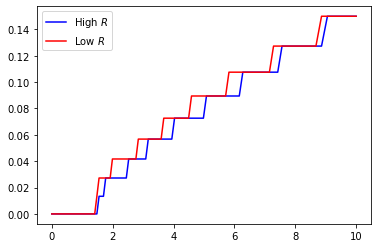

In [5]:
plt.plot(model.par.grid_m, model.sol_path.d_adj[199,0,1,:], color = 'blue', linewidth = '1.5', label = r'High $R$')
plt.plot(model.par.grid_m, model.sol_path.d_adj[200,0,1,:], color = 'red', linewidth = '1.5', label = r'Low $R$')
plt.legend()

In [3]:
model = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model.precompile_numba()
model.solve()

Solve and Simulate Along a Transition Path

In [484]:
# model.par.path_ph[199] = model.par.ph
model.par.path_ph[200] =  7.0

In [4]:
model.solve_path()
model.simulate_path()

Plot the results

In [4]:
np.shape(model.par.path_R)

(350,)

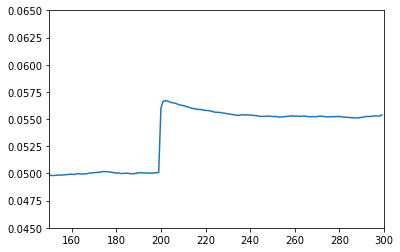

In [6]:
# define
h_path = np.mean(model.sim_path.d, axis=1)

# plot
plt.plot(range(len(h_path)),h_path)
plt.xlim(150,300)
plt.ylim(0.045,0.065)
plt.show()

## Test Relaxation Algorithm

This is to individually test each step in the relaxation algorithm for any troubleshooting

1. Define Reduced Form Supply function

In [13]:
# Write test function
def Hs_prime(x):
    
    # Parameters
    a = 9000
    b = 6.4593010477953685 - a*0.05
    
    # Set negatives to zero
    y = a*x + b
    
    return max(y,0)

2. Setup

In [66]:
# a. allocate
path_ph_ = np.zeros(model.par.path_T)
path_ph = np.zeros(model.par.path_T)

# b. setting
nu = 0.9995 # relaxation parameter
max_iter = 500 # maximum number of iterations

# Set path of prices
path_ph[:] = model.par.ph
model.par.path_ph[model.par.sim_T:model.par.sim_T+model.par.path_T] = path_ph

3. Solve and simulate along path - **start here again**

In [108]:
model.solve_path()
model.simulate_path()

4. Find implied house price

In [109]:
for t in range(model.par.path_T):
    path_ph_[t] = Hs_prime(np.mean(model.sim_path.d, axis=1)[model.par.sim_T+t])

5. Compute difference between implied and actual prices

In [110]:
max_abs_diff = np.max(np.abs(path_ph-path_ph_))
print(max_abs_diff)

49.0993239408949


Check results

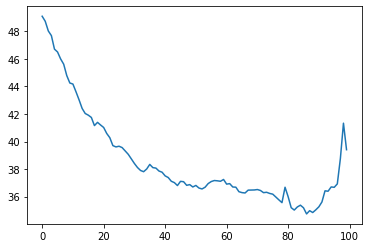

In [111]:
y = path_ph_ - path_ph
plt.plot(y)

6. Update price sequence

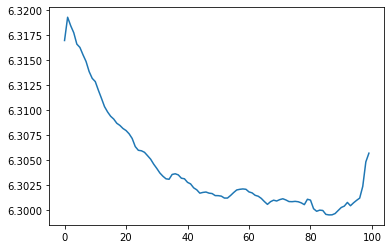

In [112]:
path_ph = nu*path_ph + (1-nu)*path_ph_
plt.plot(path_ph)

7. Add updated price sequence to model. **Then return to step 3**

In [113]:
model.par.path_ph[model.par.sim_T:model.par.sim_T+model.par.path_T] = path_ph

Test plot

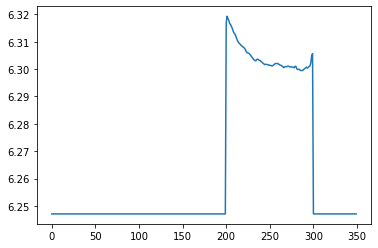

In [114]:
plt.plot(model.par.path_ph)

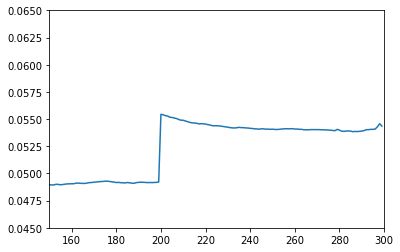

In [115]:
# define
h_path = np.mean(model.sim_path.d, axis=1)

# plot
plt.plot(range(len(h_path)),h_path)
plt.xlim(150,300)
plt.ylim(0.045,0.065)
plt.show()

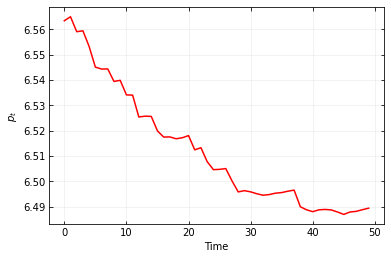

In [566]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(range(0,50),path_ph, color = 'red', label = 'Demand',zorder=2)

# ax.set_xlim(0.0,0.14)
# ax.set_ylim(2.5,9.4)
ax.set_xlabel('Time')
ax.set_ylabel(r'$p_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

# plt.savefig('../../tex/figs/IRF_ph.pdf')

## Find Equilibrium Along a Transition Path

In [2]:
# Write test function
def Hs_prime(x):
    
    # Parameters
    a = 10000
    b = 6.4593010477953685 - a*0.05
    
    # Set negatives to zero
    y = a*x + b
    
    return max(y,0)

## Apply relaxation algorithm 

In [86]:
# Initialize model and solve initial steady state
model_path = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model_path.precompile_numba()
model_path.solve()

In [89]:
# # a. allocate
# path_ph_ = np.zeros(model_path.par.path_T)
# path_ph = np.zeros(model_path.par.path_T)

# b. setting - 0.9999
nu = 2.0 # relaxation parameter
max_iter = 1000 # maximum number of iterations

# # c. Set path of prices
# path_ph[:] = model_path.par.ph
model_path.par.path_ph[model_path.par.sim_T:model_path.par.sim_T+model_path.par.path_T] = path_ph

# d. iterate
it = 0
for _ in range(max_iter):

    # ii. solve and simulate
    model_path.solve_path()
    model_path.simulate_path()

    # # iii. implied housing price
    # for t in range(model_path.par.path_T):
    #     path_ph_[t] = Hs_prime(np.mean(model_path.sim_path.d, axis=1)[model_path.par.sim_T+t])

    # iii. Implied aggregate housing demand
    H = np.mean(model_path.sim_path.d, axis=1)[model_path.par.sim_T:]
    
    # iv. difference
    max_abs_diff = np.max(np.abs(H[:-2] - h_ghost[:-2]))
    # if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 1e-8: break # test different values of this threshold

    # v. update
    path_ph = path_ph + nu*(H - h_ghost)
    
    # path_ph = nu*path_ph + (1-nu)*path_ph_
    model_path.par.path_ph[model_path.par.sim_T:model_path.par.sim_T+model_path.par.path_T] = path_ph    
    
    # vi.  increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    
    
    print(str(it)+'th iteration: dif = '+str(max_abs_diff))

1th iteration: dif = 0.00020705539667773692
2th iteration: dif = 0.00023164212059532258
3th iteration: dif = 0.0002761996847463616
4th iteration: dif = 0.0002057908974340758
5th iteration: dif = 0.0002706375145214712
6th iteration: dif = 0.000252639627437469
7th iteration: dif = 0.00023065088099116088
8th iteration: dif = 0.0001672453416086267
9th iteration: dif = 0.00017695082885166996
10th iteration: dif = 0.00016774339354240497
11th iteration: dif = 0.0001819115758848744
12th iteration: dif = 0.0002137160579770911
13th iteration: dif = 0.00021949255843308618
14th iteration: dif = 0.00022475554111218293
15th iteration: dif = 0.00025690313745320437
16th iteration: dif = 0.00025567889608784505
17th iteration: dif = 0.00025655639219770293
18th iteration: dif = 0.0002752256144331125
19th iteration: dif = 0.00031163527138972774
20th iteration: dif = 0.00028189585080145435
21th iteration: dif = 0.0002831141990010805
22th iteration: dif = 0.00028416211461545354
23th iteration: dif = 0.00026

Traceback (most recent call last):
  File "C:\Users\madsh\OneDrive - University of Copenhagen\Desktop\Thesis\code\MA_thesis\DurableConsumptionModel.py", line 510, in solve_path
    nvfi.solve_adj(t,sol_path,par,ph)
KeyboardInterrupt


KeyboardInterrupt: 

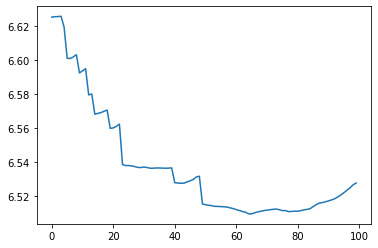

In [90]:
plt.plot(path_ph)

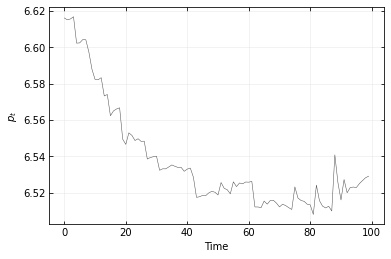

In [12]:
yhat = savgol_filter(path_ph, 30, 3)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(range(model_path.par.path_T),path_ph, color = '0.3', linestyle='-', linewidth=.5,  label = 'Demand',zorder=2)
# ax.plot(range(model_path.par.path_T),yhat, color = 'red', linestyle='--', label = 'price', zorder=2)

# ax.set_xlim(0,80)

ax.set_xlabel('Time')
ax.set_ylabel(r'$p_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

# plt.savefig('../../tex/figs/IRF_ph.pdf')

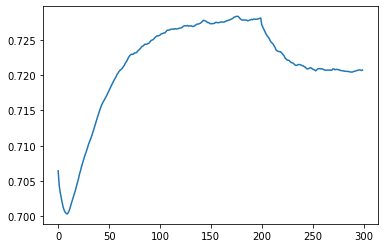

In [110]:
# define
h_path = np.mean(model_path.sim_path.c, axis=1)
# h_path = np.mean(model_path.sim_path.m, axis=1)

# plot
plt.plot(range(len(h_path)),h_path)
# plt.xlim(150,300)
# plt.ylim(0.045,0.065)
plt.show()

In [76]:
sim_T = 300

model_path = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm', 'sim_T':sim_T, 'do_print':False})
model_path.precompile_numba()
model_path.solve()
model_path.simulate()

In [24]:
np.shape(model_path.sim.c)

(300, 100000)

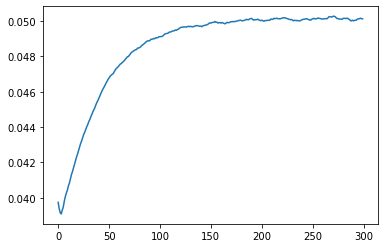

In [82]:
h_ghost = np.mean(model_path.sim.d, axis=1)

plt.plot(h_ghost)

In [83]:
h_ghost = h_ghost[200:]

In [33]:
model_path.par.path_T

100

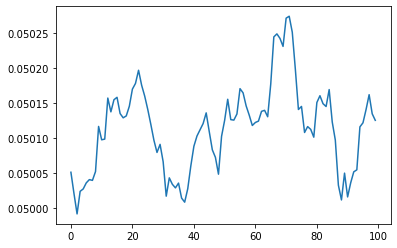

In [88]:
plt.plot(h_ghost)

In [1]:
np.shape(H)

NameError: name 'np' is not defined